In [1]:
import pandas as pd
from h3 import h3
import glob
import numpy as np
from pandas import merge
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
from datetime import datetime, timedelta
import seaborn as sns

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# Datei einlesen
supply_at_midnight = pd.read_csv('/Users/demircanm/sciebo/IS3/Research_Projects/ATIS3-Group/01 Data/sharenow_supply_data_6mo.csv')

# Config
HEX_RES = 7  # Hexagon Auflösung (siehe uber h3 library)
MIN_CHARGE_LEVEL = 50 # Wenn SoC unter 50% => Auto muss geladen werden

# 1. Wir bauen ein Dataframe, um alle möglichen Hexagon und Datum Kombinationen zu ermitteln. 
all_hexagons = pd.DataFrame(supply_at_midnight["hex_end_{}".format(HEX_RES)].unique(), columns=["hex_end_{}".format(HEX_RES)])
all_dates = pd.DataFrame(supply_at_midnight["date_start"].unique(), columns=["date_start"])

all_hexagons["key"] = 1
all_dates["key"] = 1

template = pd.merge(all_hexagons, all_dates, on=["key"])

template.drop(columns={"key"}, inplace=True)

# 2. In jedem Hexagon für jeden Tag ermitteln wir die Anzahl der Fahrzeuge, die gelanden werden müssen zum Stichzeitpunkt (00.00h)
low_charge_vehicles = supply_at_midnight[supply_at_midnight["fuel_end"]<MIN_CHARGE_LEVEL].groupby(["date_start", "hex_end_{}".format(HEX_RES)])["id"].count().reset_index()

# 3. Wir verschmelzen das Template Data Frame mit den tatsächlichen zu ladenden Fahrzeugen pro Hexagon x Datum
result = pd.merge(template, low_charge_vehicles, on = ["hex_end_7", "date_start"], how="left")

# Hexagon Datum Kombinationen, wo es keine Fahrzeuge gibt, die man laden muss, setzen wir auf 0.
# Hätten wir dieses "template" Dataframe nicht, könnten wir die "0" Fälle nicht ermitteln.
result.fillna(0, inplace=True)

# Spaltenname aussagekräftiger machen
result = result.rename(columns={"id":"number_of_low_soc_vehicle"})


# Ab hier Szenarien bestimmen...

/Users/demircanm/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
result

# 2 Calculate Distribution

In [3]:
# We estimate a Multinomial Distribution
# Calculate Fleet Size per day (n_{k})
fleet_sizes_per_day = result.groupby(["date_start"]).agg({"number_of_low_soc_vehicle":"sum"}).reset_index()
fleet_sizes_per_day = fleet_sizes_per_day.rename(columns={"number_of_low_soc_vehicle":"total_number_of_low_soc_vehicle"})

# Sum_k^K n_{k} 
fleet_size_overall = fleet_sizes_per_day[["total_number_of_low_soc_vehicle"]].sum(axis=0)["total_number_of_low_soc_vehicle"]


## 2.1 Supply Generation 

In [4]:
# p_i for low battery vehicles for multinomial distribution
low_soc_vehicles_coefficients = (result.groupby(["hex_end_{}".format(HEX_RES)]).agg({"number_of_low_soc_vehicle":"sum"})/fleet_size_overall).reset_index()
low_soc_vehicles_coefficients.rename(columns={"number_of_low_soc_vehicle":"prob"}, inplace=True)

# Sort Values
low_soc_vehicles_coefficients = low_soc_vehicles_coefficients.sort_values(by=["hex_end_{}".format(HEX_RES)])

# Convert Probabilities to Numpy Array
low_soc_vehicles_prob_array = low_soc_vehicles_coefficients["prob"].to_numpy()


## 2.2. Sample Scenarios

In [5]:
# Example 
low_soc_vehicle_sample = np.random.multinomial(1000, low_soc_vehicles_prob_array) # No of vehicles to be charged

In [6]:
NO_HEXAGONS = low_soc_vehicle_sample.shape[0]

In [7]:
NO_SCENARIOS = 1000

scenarios = np.empty(shape=[NO_SCENARIOS, NO_HEXAGONS])

In [8]:
# Generate the number of vehicles to be charged
# MLE for poisson distribution 
# MLE Estimator = 1/n * Sum D_t (Di demand at day t, n = 145 Days) (average demand per day)
poisson_mle_vehicles = fleet_sizes_per_day["total_number_of_low_soc_vehicle"].mean()

NO_OF_VEHICLES_TO_BE_CHARGED = np.random.poisson(poisson_mle_vehicles, NO_SCENARIOS)

In [9]:
for i in range(0, NO_SCENARIOS):
    low_soc_vehicle_sample = np.random.multinomial(NO_OF_VEHICLES_TO_BE_CHARGED[i], low_soc_vehicles_prob_array)
    scenarios[i] = low_soc_vehicle_sample

### 2.2.1 Clustering

In [34]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(scenarios)


### 2.2.2. Identification of Clusters 

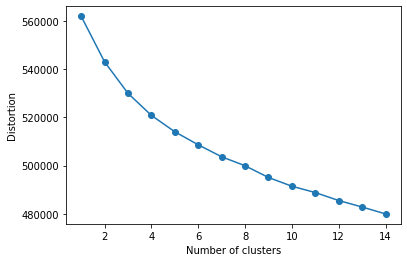

In [10]:
from sklearn.cluster import KMeans
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(scenarios)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### 2.2.2.1. K-Medoids Clusterings 

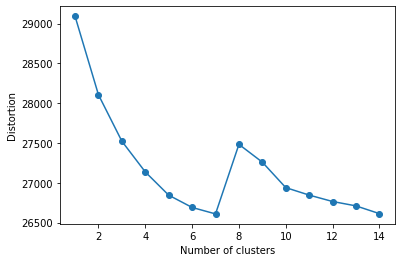

In [11]:
from sklearn_extra.cluster import KMedoids
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state = 0).fit(scenarios)
    distortions.append(kmedoids.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


### 2.2.3. Alternative Strategy using real world data as scenarios

In [12]:
from sklearn_extra.cluster import KMedoids
# Use Real World Data to Reduce Scenario
days = result["date_start"].unique()
days.sort()

NO_RL_SCENARIOS = days.shape[0]

real_scenarios = np.empty(shape=[NO_RL_SCENARIOS, NO_HEXAGONS])

idx = 0
for day in days:
    supply_at_day = result[result["date_start"] == day].sort_values(by=["hex_end_{}".format(HEX_RES)])
    supply_arr = supply_at_day["number_of_low_soc_vehicle"].to_numpy()
    real_scenarios[idx] = supply_arr
    idx += 1

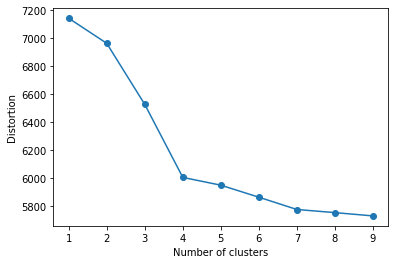

In [13]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 10
distortions = []
for i in range(1, NO_CLUSTER):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state=0).fit(real_scenarios)
    distortions.append(kmedoids.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## 2.3. Scenario Extraction

### 2.3.1. Extraction from Generated Scenarios 

In [12]:
kmedoids = KMedoids(n_clusters= 6, init='k-medoids++', random_state = 0).fit(scenarios)

In [13]:
# Access with index 0-3
kmedoids.cluster_centers_

array([[ 0.,  0.,  0.,  4.,  0.,  6.,  0.,  0.,  0.,  6.,  0.,  1.,  3.,
         3.,  0.,  2., 27.,  7.,  2., 13., 17.,  8.,  0.,  1., 12.,  1.,
         7.,  0.,  0., 11., 16.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         7.,  7., 18.,  1.,  0.,  8., 17.,  9.,  8., 16., 15., 18.,  0.,
         2.,  0., 12., 24.,  6., 15., 14., 11.,  1.,  0.,  0.,  4.,  6.,
        13., 13.,  0.,  0.,  4.,  7.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
         0., 32., 13., 19.,  7., 21.,  6., 16.,  0.,  3.,  2.,  1.,  4.,
         8.,  0., 23.,  9.,  3., 20.],
       [ 0.,  0.,  0.,  5.,  0.,  2.,  0.,  0.,  0.,  3.,  0.,  0.,  4.,
         0.,  0.,  1., 21.,  9.,  4., 14., 17., 10.,  0.,  1.,  8.,  1.,
         6.,  1.,  1.,  8., 11.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         3.,  8., 11.,  0.,  0.,  8., 19., 13.,  8., 17., 20., 15.,  0.,
         0.,  0., 11., 16.,  3., 14.,  9., 11.,  0.,  0.,  0.,  6.,  5.,
         1., 13.,  0.,  0.,  6.,  4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,

In [14]:
# Assignment of scenarios to clusters
prediction = kmedoids.predict(scenarios)

In [15]:
unique, counts = np.unique(prediction, return_counts=True)
N = sum(counts)
dict(zip(unique, counts/N))

{0: 0.163, 1: 0.243, 2: 0.154, 3: 0.156, 4: 0.127, 5: 0.157}

In [16]:
df_multinomial = pd.DataFrame(kmedoids.cluster_centers_, columns=result.hex_end_7.unique())
df_multinomial["probs"] = counts/N
df_multinomial.to_csv("scenarios_multinomial.csv",index=False)

In [17]:
df_multinomial

,871f1d4d0ffffff,871f1d48affffff,871f1d48effffff,871f1d499ffffff,871f18b25ffffff,871f1d4f0ffffff,871f1d4d2ffffff,871f1d49bffffff,871f1d49dffffff,871f1d483ffffff,871f1d4d4ffffff,871f1d488ffffff,871f18b34ffffff,871f1d489ffffff,871f18b0dffffff,871f18b35ffffff,871f18b26ffffff,871f18b2effffff,871f18b21ffffff,871f18b20ffffff,871f1d48bffffff,871f1d4f4ffffff,871f1d48dffffff,871f1d4f6ffffff,871f1d482ffffff,871f18b2cffffff,871f1d4d6ffffff,871f1d4d1ffffff,871f1d4aaffffff,871f1d4d5ffffff,871f1d4abffffff,871f1886bffffff,871f1d4f2ffffff,871f1d486ffffff,871f1d498ffffff,871f1d4a8ffffff,871f1d4a9ffffff,871f18b22ffffff,871f18b30ffffff,871f1d4c2ffffff,871f1d49affffff,871f18b24ffffff,871f18b23ffffff,871f1d4f3ffffff,871f1d48cffffff,871f1d4daffffff,871f1d4d3ffffff,871f1d4b0ffffff,871f1d4deffffff,871f1d485ffffff,871f1d4b2ffffff,871f18b04ffffff,871f1d49cffffff,871f1d49effffff,871f1d4b1ffffff,871f1d4dcffffff,871f1d4aeffffff,871f18869ffffff,871f18b29ffffff,871f1d4f1ffffff,871f18841ffffff,871f1d480ffffff,871f1d481ffffff,871f18b72ffffff,871f18b0bffffff,871f18b31ffffff,871f1d4b3ffffff,871f18b2dffffff,871f1d494ffffff,871f18b36ffffff,871f1d4c6ffffff,871f1d4ddffffff,871f18b05ffffff,871f1d4acffffff,871f18840ffffff,871f18b02ffffff,871f1d4d8ffffff,871f18b06ffffff,871f18b64ffffff,871f1d4b5ffffff,871f1d4a1ffffff,871f1d4a3ffffff,871f1d413ffffff,871f1d41bffffff,871f18b76ffffff,871f1d495ffffff,871f1896bffffff,871f1d491ffffff,871f18b01ffffff,871f1d4adffffff,871f18868ffffff,871f1d4c4ffffff,871f18b11ffffff,871f1d4c0ffffff,871f18b28ffffff,871f18b71ffffff,871f1886affffff,probs
0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,1.0,3.0,3.0,0.0,2.0,27.0,7.0,2.0,13.0,17.0,8.0,0.0,1.0,12.0,1.0,7.0,0.0,0.0,11.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,7.0,18.0,1.0,0.0,8.0,17.0,9.0,8.0,16.0,15.0,18.0,0.0,2.0,0.0,12.0,24.0,6.0,15.0,14.0,11.0,1.0,0.0,0.0,4.0,6.0,13.0,13.0,0.0,0.0,4.0,7.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,32.0,13.0,19.0,7.0,21.0,6.0,16.0,0.0,3.0,2.0,1.0,4.0,8.0,0.0,23.0,9.0,3.0,20.0,0.163
1,0.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,1.0,21.0,9.0,4.0,14.0,17.0,10.0,0.0,1.0,8.0,1.0,6.0,1.0,1.0,8.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,8.0,11.0,0.0,0.0,8.0,19.0,13.0,8.0,17.0,20.0,15.0,0.0,0.0,0.0,11.0,16.0,3.0,14.0,9.0,11.0,0.0,0.0,0.0,6.0,5.0,1.0,13.0,0.0,0.0,6.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,32.0,13.0,25.0,5.0,16.0,5.0,24.0,0.0,3.0,1.0,1.0,5.0,1.0,3.0,23.0,2.0,5.0,14.0,0.243
2,1.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,3.0,25.0,6.0,3.0,8.0,17.0,5.0,0.0,1.0,5.0,2.0,6.0,0.0,0.0,8.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,6.0,17.0,1.0,0.0,9.0,19.0,14.0,6.0,15.0,12.0,13.0,0.0,0.0,0.0,9.0,22.0,7.0,16.0,10.0,12.0,4.0,0.0,1.0,8.0,6.0,4.0,13.0,0.0,0.0,7.0,8.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,27.0,9.0,19.0,9.0,13.0,4.0,19.0,0.0,4.0,0.0,0.0,6.0,2.0,1.0,29.0,9.0,7.0,10.0,0.154
3,0.0,0.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0,1.0,17.0,13.0,3.0,16.0,13.0,11.0,0.0,1.0,9.0,1.0,7.0,0.0,1.0,9.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,9.0,17.0,0.0,1.0,8.0,15.0,16.0,8.0,12.0,16.0,13.0,0.0,3.0,0.0,11.0,21.0,3.0,14.0,10.0,17.0,1.0,0.0,0.0,9.0,3.0,8.0,12.0,0.0,0.0,8.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,29.0,9.0,20.0,7.0,15.0,5.0,20.0,0.0,4.0,2.0,0.0,4.0,1.0,0.0,32.0,2.0,5.0,17.0,0.156
4,1.0,0.0,0.0,9.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,0.0,2.0,19.0,10.0,3.0,12.0,17.0,6.0,0.0,2.0,6.0,1.0,4.0,0.0,0.0,12.0,8.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,8.0,15.0,1.0,5.0,6.0,14.0,11.0,9.0,22.0,11.0,16.0,0.0,1.0,0.0,14.0,15.0,4.0,16.0,11.0,15.0,2.0,0.0,0.0,6.0,2.0,7.0,15.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,25.0,11.0,22.0,10.0,21.0,5.0,21.0,0.0,3.0,1.0,3.0,3.0,4.0,2.0,26.0,2.0,5.0,11.0,0.127
5,1.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0,0.0,2.0,24.0,5.0,4.0,16.0,16.0,7.0,0.0,2.0,7.0,1.0,2.0,3.0,1.0,7.0,13.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,11.0,0.0,0.0,6.0,15.0,8.0,8.0,16.0,17.0,17.0,0.0,4.0,0.0,10.0,17.0,6.0,24.0,9.0,18.0,3.0,0.0,0.0,6.0,8.0,4.0,15.0,0.0,0.0,5.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29.0,11.0,20

### 2.3.2. Extraction from Real World Data

In [137]:
kmedoids_real_scenario = KMedoids(n_clusters=4, init='k-medoids++', random_state=0).fit(real_scenarios)

In [143]:
# Access with index 0-3
kmedoids_real_scenario.cluster_centers_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [144]:
# Assignment of scenarios to clusters
prediction_real_scenario = kmedoids_real_scenario.predict(real_scenarios)

In [145]:
prediction_real_scenario

array([1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 2,
       1, 3, 3, 1, 2, 1, 2, 1, 3, 3, 1, 1, 2, 2, 2, 3, 3, 1, 1, 1, 2, 1,
       3, 3, 1, 1, 2, 1, 1, 3, 3, 2, 1, 1, 2, 1, 3, 3, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 2, 1, 1, 1, 3, 1, 1, 0, 2, 3, 2, 2,
       2, 2, 2, 1, 3, 1, 1, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 3, 3, 1, 2, 2, 2, 3, 3, 2, 1, 2, 2,
       2, 3, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0])

In [152]:
unique, counts = np.unique(prediction_real_scenario, return_counts=True)
N = sum(counts)
dict(zip(unique, counts/N))

{0: 0.011560693641618497,
 1: 0.3815028901734104,
 2: 0.3236994219653179,
 3: 0.2832369942196532}